## Imports

In [52]:
from utils.data_utils import load_anndata
from train import load_config, create_model
from models.babel import BabelModel
import json
import yaml
import scanpy as sc
import pandas as pd
import numpy as np

from argparse import Namespace
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import sklearn
import torch
from pytorch_lightning import LightningModule
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    auc,
    normalized_mutual_info_score,
    roc_curve,
    silhouette_score,
)
from sklearn.preprocessing import label_binarize
from torch import nn
from torch.nn import functional as F

from models.building_blocks import Block

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from lightning.pytorch.loggers import TensorBoardLogger
import gdown

## Load data

In [53]:
test_data = load_anndata(
    mode="test",
    normalize=True,
    remove_batch_effect=False,
    target_hierarchy_level=-1,
    preload_subsample_frac=None,
)

c:\Users\adamb\miniconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [54]:
hierarchy = {'level1': ['Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'Natural Killer Cells', 'Natural Killer Cells', 'Erythroid Lineage', 'Erythroid Lineage', 'Erythroid Lineage', 'Erythroid Lineage', 'Innate Lymphoid Cells (ILCs)', 'Innate Lymphoid Cells (ILCs)'], 'level2': ['HSC', 'Progenitors', 'Progenitors', 'Progenitors', 'Monocytes', 'Monocytes', 'Dendritic Cells', 'Dendritic Cells', 'Dendritic Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Naive B Cells', 'Naive B Cells', 'Transitional B Cells', 'B1 B Cells', 'B1 B Cells', 'Plasma Cells', 'Plasma Cells', 'Plasmablasts', 'Plasmablasts', 'NK', 'NK CD158e1+', 'Erythroblasts and Precursors', 'Erythroblasts and Precursors', 'Erythroblasts and Precursors', 'Reticulocytes', 'ILC', 'ILC1'], 'level3': ['HSC', 'Lymph prog', 'G/M prog', 'MK/E prog', 'CD14+ Mono', 'CD16+ Mono', 'cDC1', 'cDC2', 'pDC', 'CD4+ T naive', 'CD4+ T activated', 'CD4+ T activated integrinB7+', 'CD4+ T CD314+ CD45RA+', 'CD8+ T naive', 'CD8+ T CD57+ CD45RO+', 'CD8+ T CD57+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T TIGIT+ CD45RA+', 'CD8+ T CD49f+', 'CD8+ T CD69+ CD45RO+', 'CD8+ T CD69+ CD45RA+', 'CD8+ T naive CD127+ CD26- CD101-', 'MAIT', 'gdT CD158b+', 'gdT TCRVD2+', 'dnT', 'T reg', 'T prog cycling', 'Naive CD20+ B IGKC+', 'Naive CD20+ B IGKC-', 'Transitional B', 'B1 B IGKC+', 'B1 B IGKC-', 'Plasma cell IGKC+', 'Plasma cell IGKC-', 'Plasmablast IGKC+', 'Plasmablast IGKC-', 'NK', 'NK CD158e1+', 'Proerythroblast', 'Erythroblast', 'Normoblast', 'Reticulocyte', 'ILC', 'ILC1'], 'description': ['Hematopoietic Stem Cells', 'Lymphoid progenitors', 'Granulocyte-Macrophage progenitors', 'Megakaryocyte-Erythroid progenitors', 'CD14+ Monocytes', 'CD16+ Monocytes', 'Conventional Dendritic Cells, subtype 1', 'Conventional Dendritic Cells, subtype 2', 'Plasmacytoid Dendritic Cells', 'Naive CD4+ T Cells', 'Activated CD4+ T Cells', 'Activated CD4+ T Cells expressing integrin β7', 'CD4+ T Cells expressing CD314 and CD45RA', 'Naive CD8+ T Cells', 'CD8+ T Cells expressing CD57 and CD45RO', 'CD8+ T Cells expressing CD57 and CD45RA', 'CD8+ T Cells expressing TIGIT and CD45RO', 'CD8+ T Cells expressing TIGIT and CD45RA', 'CD8+ T Cells expressing CD49f', 'CD8+ T Cells expressing CD69 and CD45RO', 'CD8+ T Cells expressing CD69 and CD45RA', 'Naive CD8+ T Cells expressing CD127, not CD26 or CD101', 'Mucosal-Associated Invariant T Cells', 'Gamma Delta T Cells expressing CD158b', 'Gamma Delta T Cells expressing TCRVδ2', 'Double-Negative T Cells', 'Regulatory T Cells', 'Cycling Progenitor T Cells', 'Naive B Cells expressing CD20 and IGKC', 'Naive B Cells expressing CD20, not IGKC', 'Transitional B Cells', 'B1 B Cells expressing IGKC', 'B1 B Cells not expressing IGKC', 'Plasma Cells expressing IGKC', 'Plasma Cells not expressing IGKC', 'Plasmablasts expressing IGKC', 'Plasmablasts not expressing IGKC', 'Natural Killer Cells', 'Natural Killer Cells expressing CD158e1', 'Proerythroblast', 'Erythroblast', 'Normoblast', 'Reticulocyte', 'Innate Lymphoid Cells', 'ILC1']}
hierarchy_df = pd.DataFrame(data = hierarchy)
test_data.obs = pd.merge(test_data.obs, hierarchy_df, left_on="cell_type", right_on="level3", how="left")

c:\Users\adamb\miniconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [55]:
test_data.obs

,GEX_n_genes_by_counts,GEX_pct_counts_mt,GEX_size_factors,GEX_phase,ADT_n_antibodies_by_counts,ADT_total_counts,ADT_iso_count,cell_type,batch,ADT_pseudotime_order,...,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker,is_train,level1,level2,level3,description
0,3632,4.470490,2.311520,G2M,135,4152.0,24.0,NK,s4d1,NaN,...,White,HISPANIC OR LATINO,Male,False,Nonsmoker,test,Natural Killer Cells,NK,NK,Natural Killer Cells
1,1781,8.843379,0.789157,G2M,138,6323.0,30.0,NK,s4d1,NaN,...,White,HISPANIC OR LATINO,Male,False,Nonsmoker,test,Natural Killer Cells,NK,NK,Natural Killer Cells
2,1391,4.891304,0.556811,G1,137,5038.0,48.0,CD8+ T CD69+ CD45RA+,s4d1,NaN,...,White,HISPANIC OR LATINO,Male,False,Nonsmoker,test,T Cells,CD8+ T Cells,CD8+ T CD69+ CD45RA+,CD8+ T Cells expressing CD69 and CD45RA
3,1789,7.412587,0.733487,G2M,134,3586.0,26.0,NK CD158e1+,s4d1,NaN,...,White,HISPANIC OR LATINO,Male,False,Nonsmoker,test,Natural Killer Cells,NK CD158e1+,NK CD158e1+,Natural Killer Cells expressing CD158e1
4,3644,3.935315,2.522098,G1,134,2841.0,32.0,HSC,s4d1,0.352826,...,White,HISPANIC OR LATINO,Male,False,Nonsmoker,test,Hematopoietic Stem Cells and Progenitors,HSC,HSC,Hematopoietic Stem Cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15061,1855,8.779892,0.702011,G2M,124,2093.0,12.0,Naive CD20+ B IGKC-,s4d9,NaN,...,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker,test,B Cells and Plasma Cells,Naive B Cells,Naive CD20+ B IGKC-,"Naive B Cells expressing CD20, not IGKC"
15062,1484,4.974369,0.508755,S,124,2695.0,14.0,CD8+ T naive,s4d9,NaN,...,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker,test,T Cells,CD8+ T Cells,CD8+ T naive,Naive CD8+ T Cells
15063,801,8.842443,0.232119,G1,132,3590.0,14.0,T reg,s4d9,NaN,...,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker,test,T Cells,Special T Cell Types,T reg,Regulatory T Cells
15064,1630,8.500611,0.549119,G1,133,5432.0,17.0,CD4+ T naive,s4d9,NaN,...,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker,test,T Cells,CD4+ T Cells,CD4+ T naive,Naive CD4+ T Cells


## Load Latent

In [56]:
LATENT_NAME = "latent_omiae"
DATA_PATH = "../data/latent/latent_omiae_test"

In [6]:
LATENT_NAME = "omivae_latent"
DATA_PATH = "../data/latent/omivae_2024-06-15_14-02-51/latent_test.zip"

In [16]:
LATENT_NAME = "babel_latent_adt"
DATA_PATH = "../data/latent/adam_babel/adam_babel_latent_test_adt"

In [34]:
LATENT_NAME = "babel_latent_gex"
DATA_PATH = "../data/latent/adam_babel/adam_babel_latent_test_gex"

In [57]:
LATENT_NAME = "latent_omiae"
DATA_PATH = "../data/latent/omiae_simple_2024-06-15_10-32-21/latent_omiae_test.zip"

In [58]:
test_data.obsm[LATENT_NAME] = torch.load(DATA_PATH)

## Visualize latent

### UMAP

In [59]:
# UMAP representation of latent embedding
# Clustering by all call_types
import scanpy as sc
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Input: AnnData Object, 'embedding name', n_neighnors
# Silhouttte Score: Ranges from -1 to 1, higher values indicate better cluster separation
# Davies-Bouldine-Index: A low index indicates that clusters are well separates

def umap_and_scores(adata, embedding_key, n_neighbors=20, label_columns=["cell_type"]):
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep=embedding_key)
    sc.tl.umap(adata)

    for label_column in label_columns:
        plot_title = f'UMAP Plot using {embedding_key}'
        sc.pl.umap(adata, color=label_column, size=20, ncols=1, title=plot_title)
        plt.show()

        umap_coords = adata.obsm['X_umap']
        labels = adata.obs[label_column]

        sil_score = silhouette_score(umap_coords, labels)
        print(f'Silhouette-Score for {embedding_key}: {sil_score}')

        db_score = davies_bouldin_score(umap_coords, labels)
        print(f'Davies-Bouldin-Index for {embedding_key}: {db_score}')

# Example
# umap_and_scores(adata, 'latent_embedding_combined_3', n_neighbors=30)

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


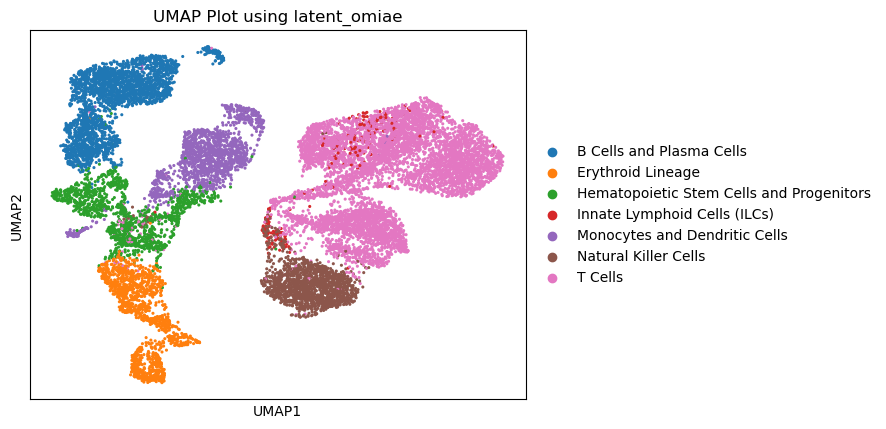

Silhouette-Score for latent_omiae: 0.30979830026626587
Davies-Bouldin-Index for latent_omiae: 1.3509016191526253


c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


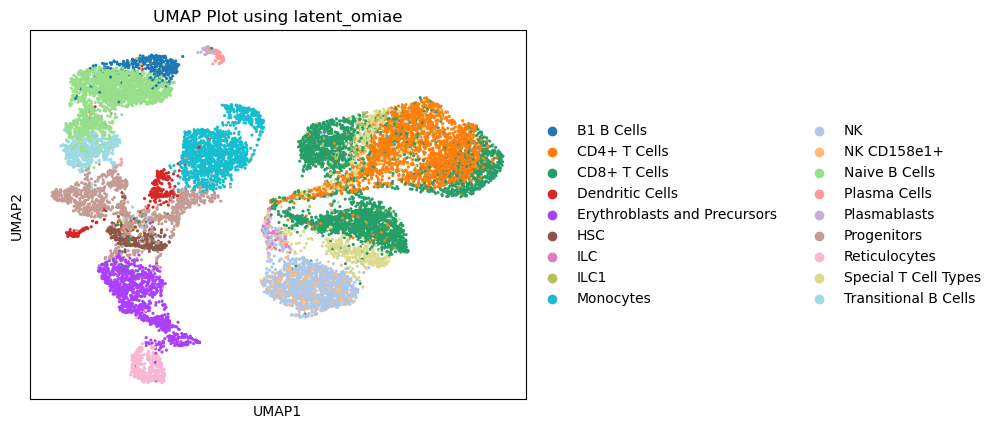

Silhouette-Score for latent_omiae: 0.0545005165040493
Davies-Bouldin-Index for latent_omiae: 6.220562710580265


c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


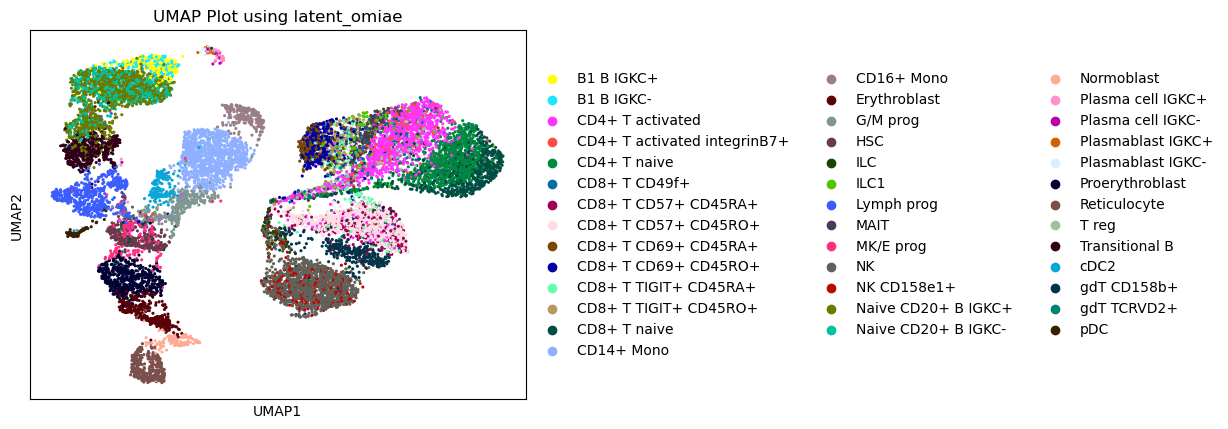

Silhouette-Score for latent_omiae: 0.0528724268078804
Davies-Bouldin-Index for latent_omiae: 14.65331462685268


In [60]:
umap_and_scores(test_data, LATENT_NAME, 15, ["level1", "level2", "level3"])

In [61]:
# PCA representation of latent embedding
# Clustering by all call_types
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Input: AnnData Object, 'embedding name', n_components
# Silhouttte Score: Ranges from -1 to 1, higher values indicate better cluster separation
# Davies-Bouldine-Index: A low index indicates that clusters are well separates
def pca_and_scores_for_embedding(adata, embedding_key, n_components=10, label_columns=["cell_type"]):
    embedding_data = adata.obsm[embedding_key]

    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embedding_data)

    adata.obsm['X_pca'] = pca_result

    for label_column in label_columns:
        plot_title = f'UMAP Plot using {embedding_key}'
        plt.figure(figsize=(8, 6))
        sc.pl.pca(adata, color=label_column, size=20, ncols=1, title = plot_title)
        plt.show()

        pca_coords = adata.obsm['X_pca']
        labels = adata.obs[label_column]

    # Calculate Silhouetten-Score
    sil_score = silhouette_score(pca_coords, labels)
    print(f'Silhouetten-Score for {embedding_key}: {sil_score}')

    # Calculate Davies-Bouldin-Index
    db_score = davies_bouldin_score(pca_coords, labels)
    print(f'Davies-Bouldin-Index for {embedding_key}: {db_score}')

# Example
# pca_and_scores_for_embedding(adata, 'latent_embedding_adt_3', n_components=10)

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 800x600 with 0 Axes>

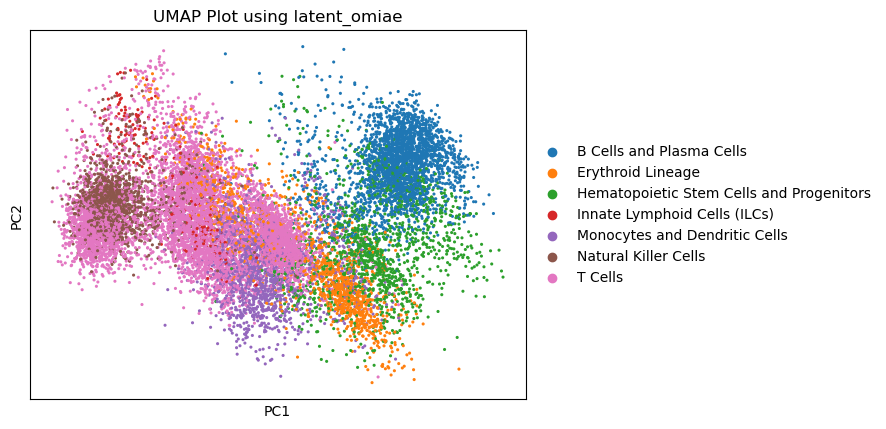

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 800x600 with 0 Axes>

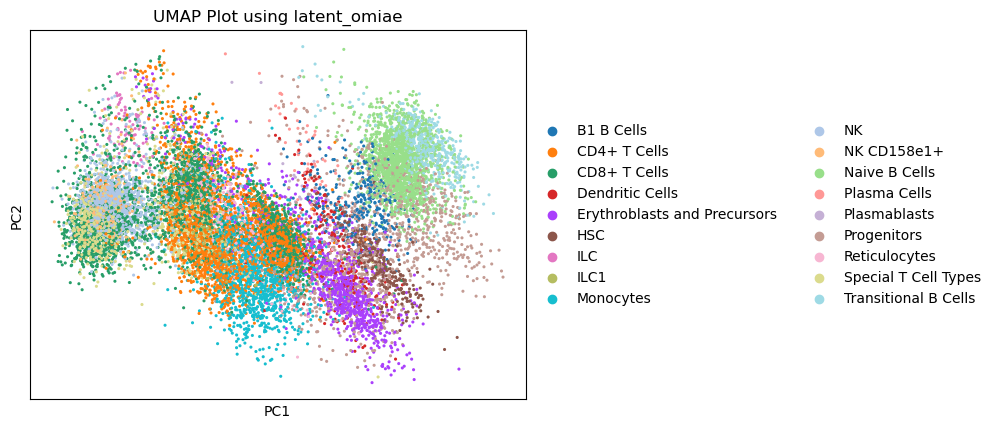

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 800x600 with 0 Axes>

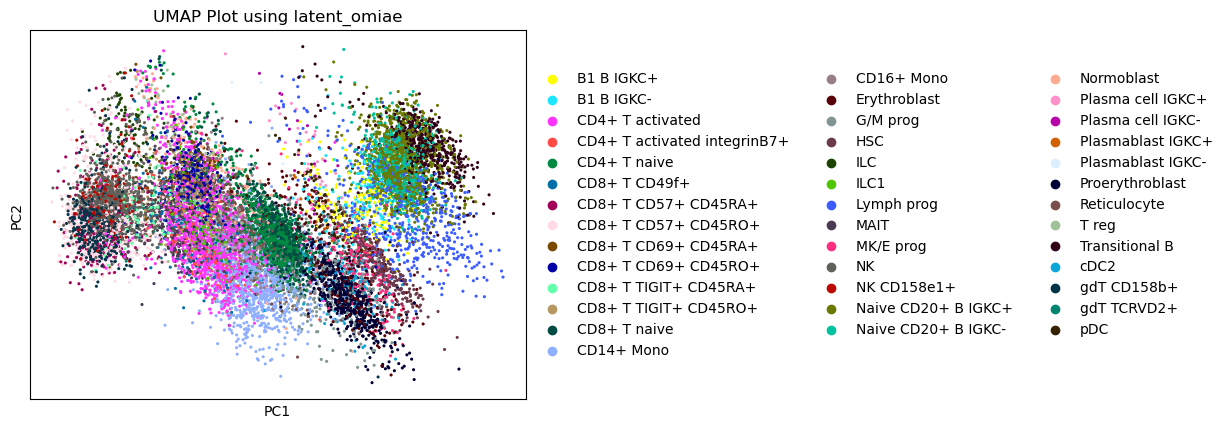

Silhouetten-Score for latent_omiae: 0.040296976439856386
Davies-Bouldin-Index for latent_omiae: 4.8282559732273


In [62]:
pca_and_scores_for_embedding(test_data, LATENT_NAME, 10, ["level1", "level2", "level3"])

## Compute metrics

In [63]:
LABELS_COLUMN = "level1"
X = test_data.obsm[LATENT_NAME]

### Silhouette score

In [64]:
silhouette_score1 = sklearn.metrics.silhouette_score(X, labels=test_data.obs["level1"])
silhouette_score2 = sklearn.metrics.silhouette_score(X, labels=test_data.obs["level2"])
silhouette_score3 = sklearn.metrics.silhouette_score(X, labels=test_data.obs["level3"])

In [65]:
print(f"Silhouette score for level 1: {silhouette_score1}")
print(f"Silhouette score for level 2: {silhouette_score2}")
print(f"Silhouette score for level 3: {silhouette_score3}")

Silhouette score for level 1: 0.20011337101459503
Silhouette score for level 2: 0.032275088131427765
Silhouette score for level 3: 0.044666122645139694


For n_clusters = 7 The average silhouette_score is : 0.20011337
For n_clusters = 18 The average silhouette_score is : 0.032275088
For n_clusters = 40 The average silhouette_score is : 0.044666123


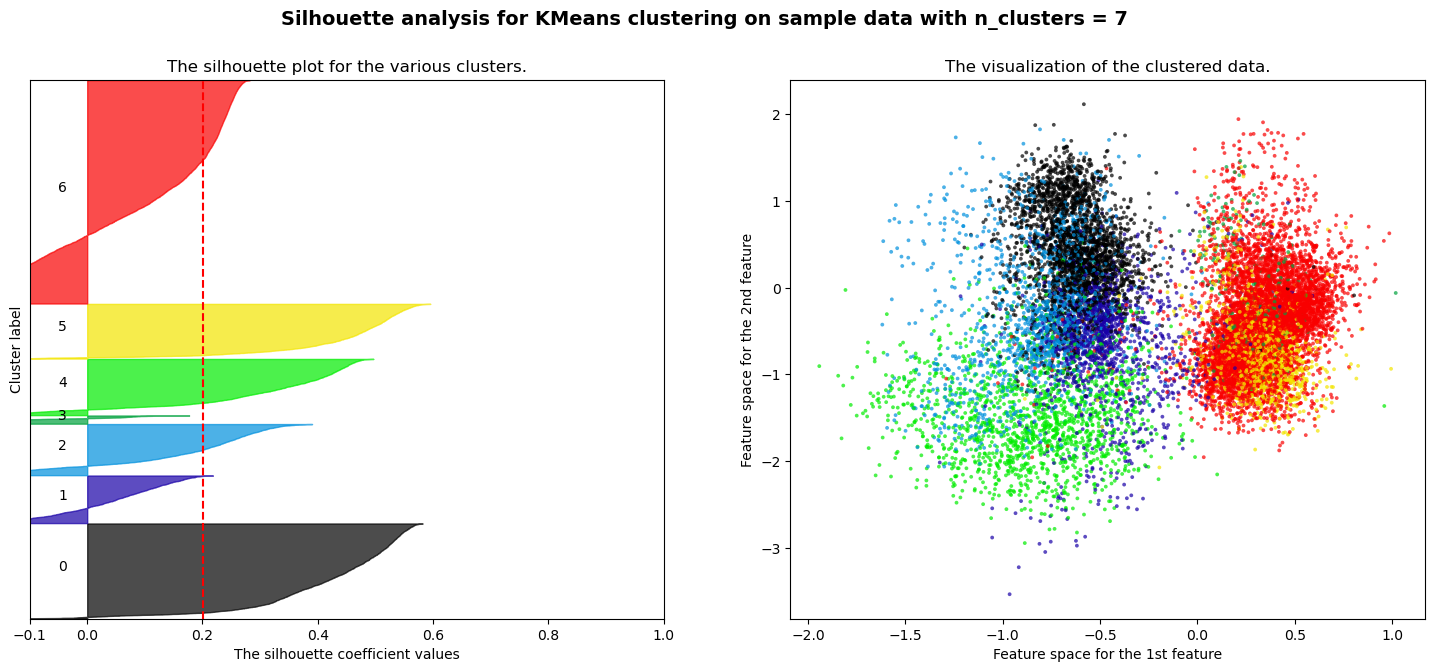

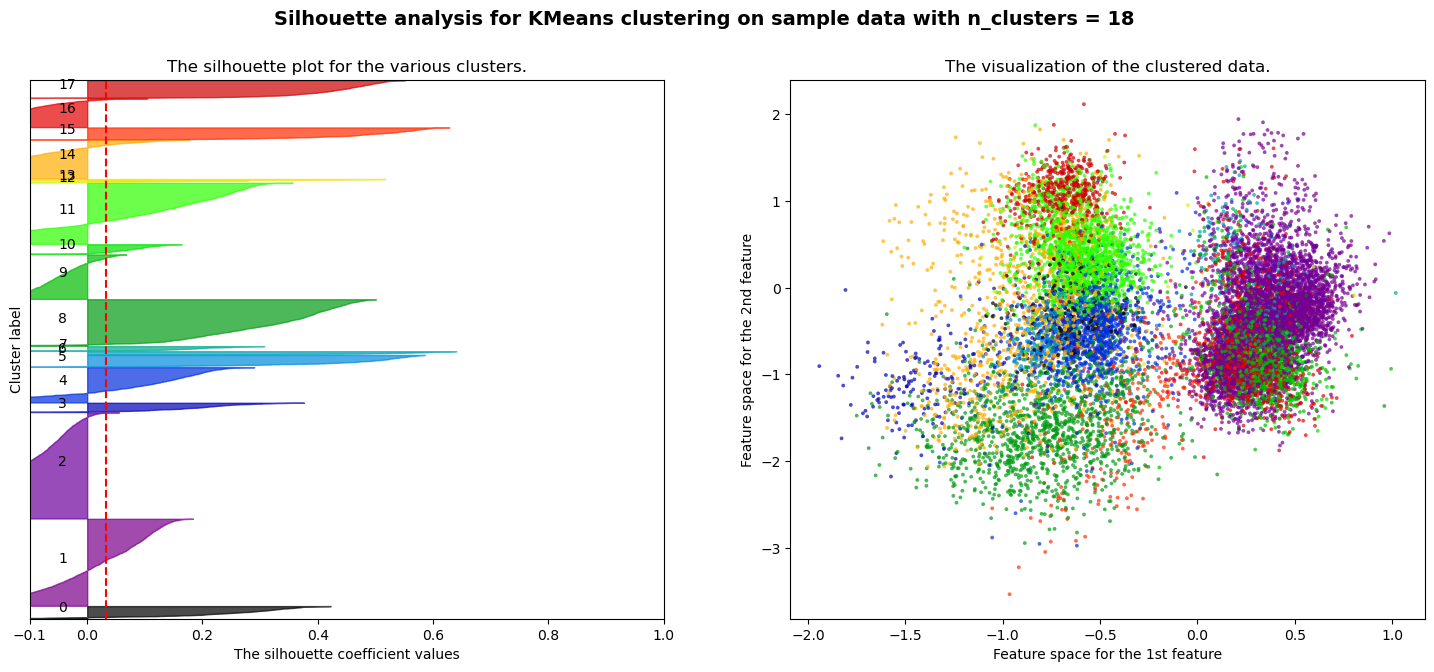

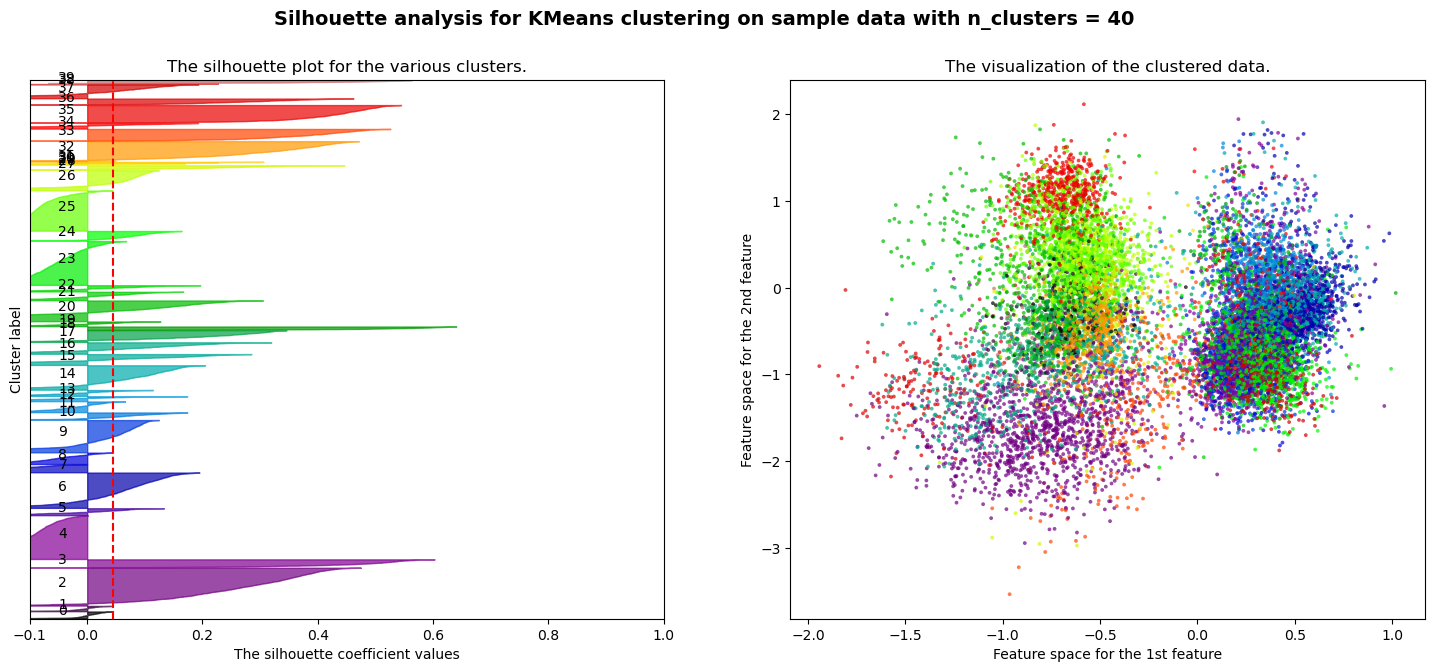

In [66]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score


for label_name in ["level1", "level2", "level3"]:
    y = test_data.obs[label_name]
    n_clusters = y.nunique()
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # # Initialize the clusterer with n_clusters value and a random generator
    # # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    label_encoder = LabelEncoder()
    cluster_labels = label_encoder.fit_transform(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## Downstream task

In [67]:
LATENT_DIM = 16
DATA = test_data
LEVEL = 'level3'
HIDDEN_DIM = 16 * 4

In [68]:
# Extract the labels (cell types)
labels = DATA.obs[LEVEL].values

# Encode labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert to PyTorch tensors
X = torch.tensor(DATA.obsm[LATENT_NAME], dtype=torch.float32)
y = torch.tensor(labels_encoded, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\adamb\AppData\Local\Temp\ipykernel_26028\2057320055.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(DATA.obsm[LATENT_NAME], dtype=torch.float32)


In [69]:
from models.building_blocks import Block


class ClassificationModel(pl.LightningModule):
    def __init__(self, latent_dim, num_classes, hidden_dim, do_batch_norm=False):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )
        self.loss = nn.CrossEntropyLoss()  # Adjust

    def forward(self, z):
        return self.layers(z)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        
        return loss

    def configure_optimizers(self):
        # Define optimizer here
        optimizer = torch.optim.Adam(
            self.parameters(), lr=0.001
        )  # Adjust learning rate
        return optimizer

In [70]:
output_dim = len(np.unique(labels_encoded))

model = ClassificationModel(latent_dim=LATENT_DIM,
                            num_classes=output_dim,
                            hidden_dim=HIDDEN_DIM,
                            do_batch_norm=False)

# Define a trainer
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'logs/classification_checkpoints/{LATENT_NAME}',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)
logger = TensorBoardLogger("./logs", name=f"{LATENT_NAME}_classifing_logs")
trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint_callback])

# Train the model
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 3.7 K 
1 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [71]:
# Loading the best model for evaluation
best_model_path = checkpoint_callback.best_model_path
best_model = ClassificationModel.load_from_checkpoint(
    best_model_path,
    latent_dim=LATENT_DIM,
    num_classes=output_dim,
    hidden_dim=HIDDEN_DIM,
    do_batch_norm=False).cpu()

# Evaluate the model on test set
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 77.64%


In [72]:
output = best_model(X_test)
_, predicted = torch.max(output.data, 1)

In [73]:
def print_metrics(y_true, y_pred):
    balanced_accuracy_score = sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
    accuracy_score = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    
    print(f"Accuracy score: {accuracy_score}")
    print(f"Balanced accuracy score: {balanced_accuracy_score}")
    print(f"F1 score: {f1_score}")

In [74]:
print_metrics(y_test, predicted)

Accuracy score: 0.7763769077637691
Balanced accuracy score: 0.6210705492163321
F1 score: 0.6098491773272356
